In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('./data/data_indexes_moex_log_returns.csv', index_col=0)

In [6]:
from typing import List, Union

def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = (y_true - y_pred).abs()
    naive_average_errors = (y_true - naive_forecast).abs()

    result = average_errors.mean() / naive_average_errors.mean()
    return result


def ZBMAE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Zero-Benchmarked Mean Absolute Error (ZBMAE) между фактическими и прогнозируемыми значениями.

    ZBMAE сравнивает среднюю абсолютную ошибку прогноза с средней абсолютной ошибкой наивного прогноза, который предполагает, что все прогнозируемые значения равны нулю. Это может быть полезно для временных рядов, где ожидается, что значения будут вокруг нуля.

    Параметры:
        y_true (pd.Series): Серия с фактическими значениями.
        y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
        float: Значение ZBMAE.
    '''
    zero_forecast = 0

    average_errors = (y_true - y_pred).abs()
    naive_average_errors = (y_true - zero_forecast).abs()

    result = average_errors.mean() / naive_average_errors.mean()
    return result

def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps) / 2
    result = (100 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result

def MDA(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Directional Accuracy (MDA) между фактическими и прогнозируемыми значениями.

    MDA измеряет процент времени, когда прогноз и фактическое значение имеют одинаковое направление изменений (например, оба увеличиваются или оба уменьшаются).

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)

    result = (100 / len(y_true)) * np.sum(y_pred_sign == y_true_sign)
    return result
    
    

class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

        self.y_val = None
        self.X_val = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
        '''
        if other_variables.isna().any().any():
            print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

        self.X = pd.concat([self.X, other_variables], axis=1, join='inner')

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(
            self, 
            horizon: int = 25, 
            num_recent_folds: int = None, 
            validation_part: float = None
            ) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
            validation_part (float): Процентное отношение объема исходных данных, отводимое для валидационного набора. Этот параметр особенно полезен в случаях, когда оптимизация гиперпараметров модели требует значительного времени. Рекомендуется однократно настроить гиперпараметры на валидационном наборе и применять их для последующих разбиений (фолдов), избегая повторного обучения на каждом фолде.
                В случае отсутствия значения параметра, валидационная часть данных не формируется.
        '''

        if validation_part is not None:
            if not 0 <= validation_part <= 1:
                raise ValueError("validation_part может быть только числом в отрезке от 0 до 1 включительно")
            
            last_val_obs = int(self.y.shape[0] * validation_part)

            self.y_val, self.y = self.y.iloc[:last_val_obs], self.y.iloc[last_val_obs:]
            self.X_val, self.X = self.X.iloc[:last_val_obs, :], self.X.iloc[last_val_obs:, :]

        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)
        self.mda = MDA(self.y_true, self.y_pred)
        self.zbmae = ZBMAE(self.y_true, self.y_pred)

        print(f'MASE: {self.mase:.2f} (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)')
        print(f'SMAPE: {self.smape:.2f}% (на сколько % в среднем модель ошибается)')
        print(f'MDA: {self.mda:.2f}% (% случаев, когда знак прогноза совпадает с фактическим знаком)')
        print(f'ZBMAE: {self.zbmae:.2f} (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

In [7]:
ts = TimeSeriesProcessor(data=data.MOEXCN)

Новый тип индексов: pd.DatetimeIndex


In [8]:
ts.add_lags(lags=[1, 2, 3, 4, 5, 10, 30])

In [9]:
ts.get_folds(horizon=20, validation_part=0.2, num_recent_folds=40)

# Тестирование различных моделей

### Случайный лес

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
smape_scorer = make_scorer(SMAPE)

def objective(trial):
    
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Количество деревьев
    'max_depth': trial.suggest_int('max_depth', 3, 10),  # Максимальная глубина деревьев
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Минимальное количество выборок для разделения внутреннего узла
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),  # Минимальное количество выборок, необходимых для каждого листа
    'max_features': trial.suggest_int('max_features', 1, 10),  # Максимальное количество признаков для разбиения
}
    
    regressor = RandomForestRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=smape_scorer, 
            cv=5))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-03-16 12:08:09,815] A new study created in memory with name: no-name-17895302-bca8-4076-8d8d-89c81e52c673
[I 2024-03-16 12:08:12,094] Trial 0 finished with value: 160.2267646088927 and parameters: {'n_estimators': 649, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 3}. Best is trial 0 with value: 160.2267646088927.
[I 2024-03-16 12:08:14,288] Trial 1 finished with value: 159.42447081484008 and parameters: {'n_estimators': 552, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 18, 'max_features': 2}. Best is trial 1 with value: 159.42447081484008.
[I 2024-03-16 12:08:17,799] Trial 2 finished with value: 159.2208483726156 and parameters: {'n_estimators': 985, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 3}. Best is trial 2 with value: 159.2208483726156.
[I 2024-03-16 12:08:24,502] Trial 3 finished with value: 156.78474558728172 and parameters: {'n_estimators': 932, 'max_depth': 8, 'min_samples_split'

In [28]:
study.best_params

{'n_estimators': 102,
 'max_depth': 10,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 5}

In [33]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [160.2267646088927, 159.42447081484008, 159.2208483726156,
                    156.78474558728172, 156.1157975235699, 159.33292069047906,
                    160.40822755787264, 156.5584938041035, 158.19263277662424,
                    155.75713832801327, 159.10626905675738, 154.51155788339685,
                    155.37331868505672, 155.0886062476028, 156.48156618294684,
                    155.56074021413482, 156.02401202530876, 161.41872420235057,
                    155.88329637119847, 159.3908441018757, 155.6579353379652,
                    155.22388231062573, 155.26660235226018, 155.42688865055806,
                    156.507668648236, 155.60945291530814, 156.54776169504348,
                    156.37820638269756, 157.07948924538428, 156.75550377603025,
                    156.55124103158406, 156.30736191246908, 155.12408568972097,
                    155.23002619753336, 157.44269693696324, 156.152486359589,
                    156.2815530905043, 160.14634781365268, 157.75283751945935,
                    157.71803228457546, 155.18484516349434, 155.93985726944555,
                    155.3872524889955, 156.08650351726, 155.5698641092011,
                    156.87836764406345, 155.5623861729919, 156.3658242913871,
                    156.67298799982805, 155.86732892339214, 158.57199469124998,
                    155.46192654101694, 155.50836029778634, 155.12980016667197,
                    155.35488760855114, 156.2100202580661, 160.68316184679244,
                    154.9745607667066, 157.0522634333403, 155.8442522616981,
                    157.32875150411255, 156.20288608491916, 156.1797166520243,
                    156.0820492461067, 155.20648171772115, 156.28254010922086,
                    155.98201826241007, 159.85522374726065, 157.01305819752665,
                    157.25678976948853, 155.92918472162313, 154.98966812854462,
                    156.1473853822868, 156.17331326974286, 156.32795923736867,
                    156.4024686034424, 155.13083939826643, 156.20385656906797,
                    155.85306522929397, 156.23720526525557, 153.9506418017966,
                    156.33696805080208, 156.0562734259119, 155.90282886403742,
                    155.70162910779632, 154.97507306325687, 155.94899646764162,
                    156.2702109757908, 157.53753669233572, 157.92339890412595,
                    157.1412488958707, 155.622030776838, 155.1355917671852,
                    156.75146090682333, 156.59861697367302, 155.97581435411183,
                    157.0859793682144, 155.5164528658572, 155.65015044632605,
                    155.1743834853067]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [160.2267646088927, 159.42447081484008, 159.2208483726156,

In [34]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                   50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                                   62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
                                   74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
                                   86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                                   98, 99],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [4, 8, 5, 8, 8, 4, 6, 7, 9, 10, 10, 10, 10, 10, 9, 9, 7, 3, 10,
                    6, 9, 10, 10, 9, 8, 10, 9, 10, 8, 7, 9, 10, 10, 10, 9, 8, 10,
                    4, 8, 5, 9, 9, 10, 10, 9, 10, 9, 10, 10, 9, 5, 10, 10, 10, 9,
                    10, 10, 8, 8, 9, 8, 7, 9, 10, 10, 9, 10, 3, 9, 6, 10, 10, 10,
                    10, 9, 10, 10, 8, 9, 10, 10, 10, 10, 10, 9, 10, 10, 10, 6, 10,
                    7, 10, 9, 10, 10, 9, 10, 10, 9, 10],
              'xaxis': 'x',
              'y': [160.2267646088927, 159.42447081484008, 159.2208483726156,
                    156.78474558728172, 156.1157975235699, 159.33292069047906,
                    160.40822755787264, 156.5584938041035, 158.19263277662424,
                    155.75713832801327, 159.10626905675738, 154.51155788339685,
                    155.37331868505672, 155.0886062476028, 156.48156618294684,
                    155.56074021413482, 156.02401202530876, 161.41872420235057,
                    155.88329637119847, 159.3908441018757, 155.6579353379652,
                    155.22388231062573, 155.26660235226018, 155.42688865055806,
                    156.507668648236, 155.60945291530814, 156.54776169504348,
                    156.37820638269756, 157.07948924538428, 156.75550377603025,
                    156.55124103158406, 156.30736191246908, 155.12408568972097,
                    155.23002619753336, 157.44269693696324, 156.152486359589,
                    156.2815530905043, 160.14634781365268, 157.75283751945935,
                    157.71803228457546, 155.18484516349434, 155.93985726944555,
                    155.3872524889955, 156.08650351726, 155.5698641092011,
                    156.87836764406345, 155.5623861729919, 156.3658242913871,
                    156.67298799982805, 155.86732892339214, 158.57199469124998,
                    155.46192654101694, 155.50836029778634, 155.12980016667197,
                    155.35488760855114, 156.2100202580661, 160.68316184679244,
                    154.9745607667066, 157.0522634333403, 155.8442522616981,
                    157.32875150411255, 156.20288608491916, 156.1797166520243,
                    156.0820492461067, 155.20648171772115, 156.28254010922086,
                    155.98201826241007, 159.85522374726065, 157.01305819752665,
                    157.25678976948853, 155.92918472162313, 154.98

In [35]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [n_estimators (IntDistribution):
                                0.018032678790847415<extra></extra>,
                                min_samples_split (IntDistribution):
                                0.029864133187308645<extra></extra>,
                                min_samples_leaf (IntDistribution):
                                0.06310678748000091<extra></extra>, max_features
                                (IntDistribution):
                                0.18144886525980833<extra></extra>, max_depth
                                (IntDistribution):
                                0.7075475352820347<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.02, 0.03, 0.06, 0.18, 0.71],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.018032678790847415, 0.029864133187308645,
                    0.06310678748000091, 0.18144886525980833, 0.7075475352820347],
              'y': [n_estimators, min_samples_split, min_samples_leaf,
                    max_features, max_depth]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [30]:
# Модель случайного леса
rf_model = RandomForestRegressor(**study.best_params)

y_pred_list_rf = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    rf_model.fit(X_train, y_train)
    y_pred_rf = pd.Series(rf_model.predict(X_test), index=X_test.index)
    y_pred_list_rf.append(y_pred_rf) 

100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


In [31]:
ts.get_model_result(y_pred_list_rf) 

MASE: 0.75 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 161.96% (на сколько % в среднем модель ошибается)
MDA: 53.25% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.00 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


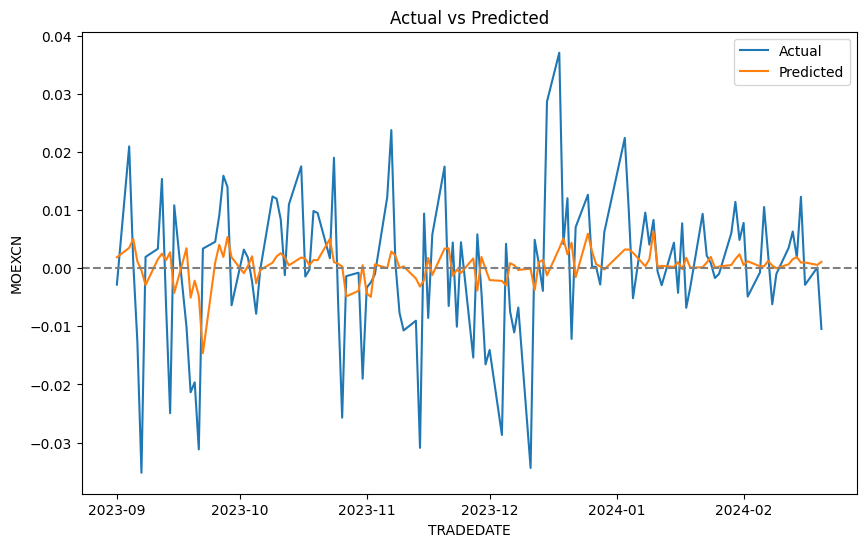

In [32]:
ts.get_visualisation(start_date='2023-09-01')

### Градиентный бустинг

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

# Модель градиентного бустинга
gb_model = GradientBoostingRegressor()

y_pred_list_gb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    gb_model.fit(X_train, y_train)
    y_pred_gb = pd.Series(gb_model.predict(X_test), index=X_test.index)
    y_pred_list_gb.append(y_pred_gb)

100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


In [11]:
ts.get_model_result(y_pred_list_gb) 

MASE: 0.76 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 160.36% (на сколько % в среднем модель ошибается)
MDA: 56.62% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.01 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


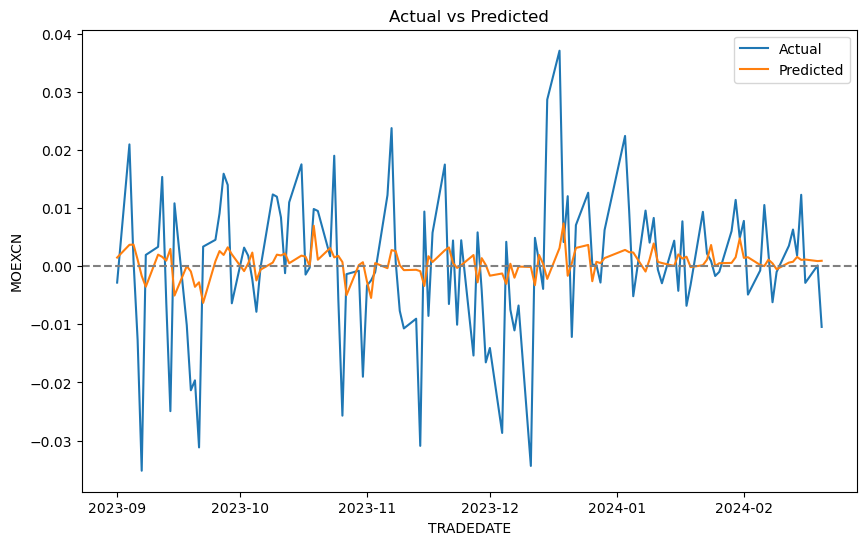

In [12]:
ts.get_visualisation(start_date='2023-09-01')

### SVR модель

In [13]:
from sklearn.svm import SVR

svr_model = SVR()

y_pred_list_svr = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    svr_model.fit(X_train, y_train)
    y_pred_svr = pd.Series(svr_model.predict(X_test), index=X_test.index)
    y_pred_list_svr.append(y_pred_svr)

100%|██████████| 40/40 [00:00<00:00, 105.21it/s]


In [14]:
ts.get_model_result(y_pred_list_svr) 

MASE: 1.82 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 156.94% (на сколько % в среднем модель ошибается)
MDA: 46.12% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 2.42 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


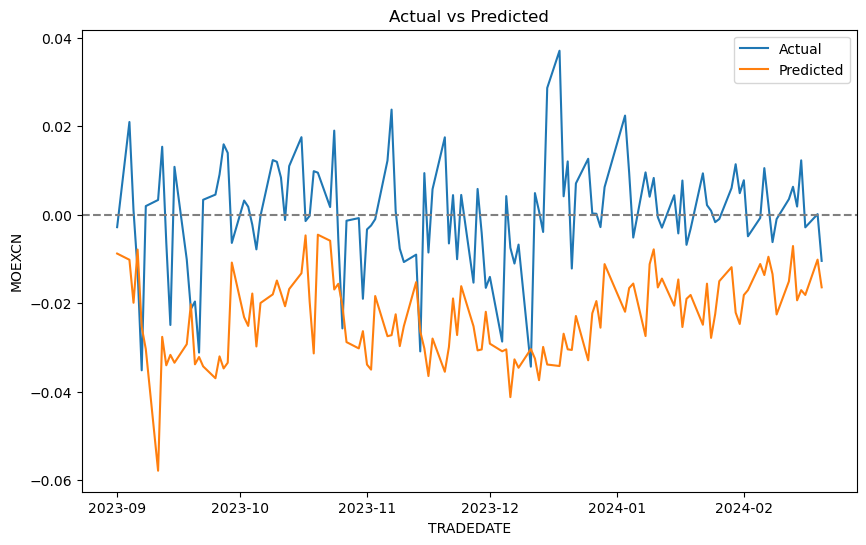

In [15]:
ts.get_visualisation(start_date='2023-09-01')

### Адаптивный бустинг

In [16]:
from sklearn.ensemble import AdaBoostRegressor

adaboost_model = AdaBoostRegressor()

y_pred_list_adaboost = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    adaboost_model.fit(X_train, y_train)
    y_pred_adaboost = pd.Series(adaboost_model.predict(X_test), index=X_test.index)
    y_pred_list_adaboost.append(y_pred_adaboost)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:08<00:00,  4.95it/s]


In [17]:
ts.get_model_result(y_pred_list_adaboost) 

MASE: 0.82 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 159.09% (на сколько % в среднем модель ошибается)
MDA: 54.75% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.09 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


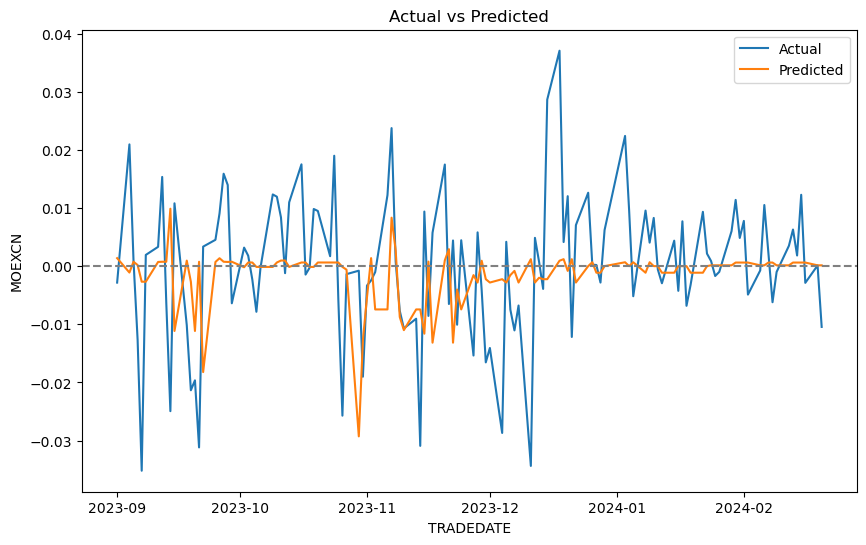

In [18]:
ts.get_visualisation(start_date='2023-09-01')

### Lasso-регрессия

In [50]:
from sklearn.linear_model import Lasso

model = Lasso()

y_pred_list = []
    
for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    
    model.fit(X_train, y_train)

    y_pred = pd.Series(
        model.predict(X_test),
        index=X_test.index
    )

y_pred_list.append(y_pred)

100%|██████████| 40/40 [00:00<00:00, 305.60it/s]


In [51]:
ts.get_model_result(y_pred_list) 

MASE: 0.76 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 168.39% (на сколько % в среднем модель ошибается)
MDA: 60.00% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 0.99 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


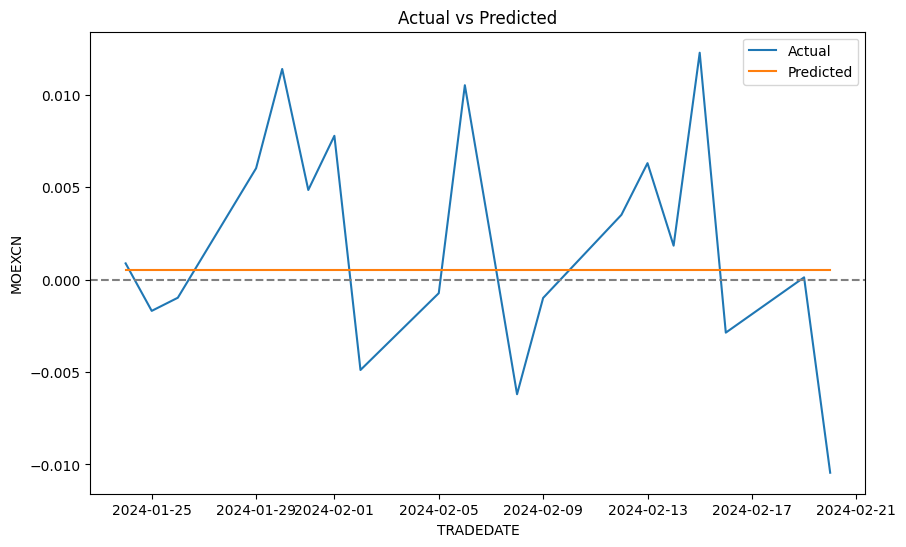

In [52]:
ts.get_visualisation(start_date='2023-09-01')

### Ridge-регрессия

In [22]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

y_pred_list_ridge = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = pd.Series(ridge_model.predict(X_test), index=X_test.index)
    y_pred_list_ridge.append(y_pred_ridge)

100%|██████████| 40/40 [00:00<00:00, 201.23it/s]


In [23]:
ts.get_model_result(y_pred_list_ridge) 

MASE: 0.75 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 174.04% (на сколько % в среднем модель ошибается)
MDA: 53.75% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.00 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


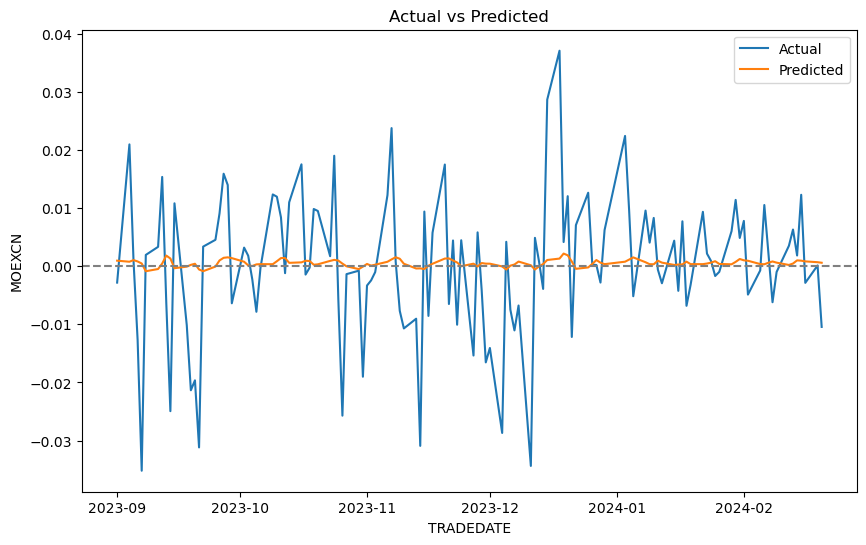

In [24]:
ts.get_visualisation(start_date='2023-09-01')

### К-ближайших соседей 

In [25]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()

y_pred_list_knn = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    knn_model.fit(X_train, y_train)
    y_pred_knn = pd.Series(knn_model.predict(X_test), index=X_test.index)
    y_pred_list_knn.append(y_pred_knn)

100%|██████████| 40/40 [00:00<00:00, 92.61it/s]


In [26]:
ts.get_model_result(y_pred_list_knn) 

MASE: 0.80 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 147.46% (на сколько % в среднем модель ошибается)
MDA: 51.12% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.07 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


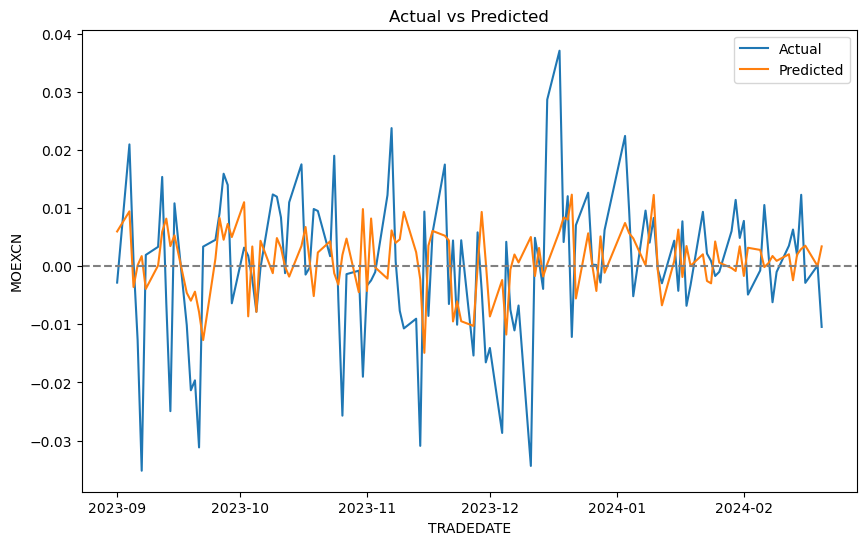

In [27]:
ts.get_visualisation(start_date='2023-09-01')

### XGBoost

In [39]:
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
smape_scorer = make_scorer(ZBMAE)

def objective(trial):
    
    param = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Скорость обучения
    'max_depth': trial.suggest_int('max_depth', 3, 10),  # Максимальная глубина деревьев
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),  # Минимальное снижение значения функции потерь, чтобы сделать разделение
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),  # L1 регуляризация
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),  # L2 регуляризация
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Доля наблюдений, используемая для обучения каждого дерева
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Доля признаков, используемая для обучения каждого дерева
    'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),  # Минимальный вес дочерних узлов
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Количество деревьев
    }
    
    regressor = xgb.XGBRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=smape_scorer, 
            cv=5))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

[I 2024-03-16 02:17:05,292] A new study created in memory with name: no-name-428cedb5-766f-48ca-92f5-0a33b8038459
[I 2024-03-16 02:17:05,370] Trial 0 finished with value: 1.0203450920151869 and parameters: {'learning_rate': 0.29551256076207627, 'max_depth': 7, 'gamma': 0.23846634295861946, 'reg_alpha': 2.6504881038471185e-05, 'reg_lambda': 5.014051206743228e-07, 'subsample': 0.5446541604362286, 'colsample_bytree': 0.9515382536427248, 'min_child_weight': 8.655097379566703, 'n_estimators': 102}. Best is trial 0 with value: 1.0203450920151869.
[I 2024-03-16 02:17:05,455] Trial 1 finished with value: 1.0185113009379925 and parameters: {'learning_rate': 0.153005459913329, 'max_depth': 10, 'gamma': 0.2680695748555063, 'reg_alpha': 0.00014792620324231774, 'reg_lambda': 19.13042159756022, 'subsample': 0.7640470109843891, 'colsample_bytree': 0.5061567444501545, 'min_child_weight': 8.719889836058599, 'n_estimators': 157}. Best is trial 1 with value: 1.0185113009379925.
[I 2024-03-16 02:17:05,637

In [40]:
study.best_params

{'learning_rate': 0.21487467345935785,
 'max_depth': 7,
 'gamma': 0.009960544494262157,
 'reg_alpha': 6.69873031249759e-08,
 'reg_lambda': 0.007747691684540053,
 'subsample': 0.7872623656877591,
 'colsample_bytree': 0.8672777386494386,
 'min_child_weight': 5.592451334492524,
 'n_estimators': 881}

In [41]:
optuna.visualization.plot_optimization_history(study)

In [42]:
optuna.visualization.plot_slice(study)

In [48]:
optuna.visualization.plot_param_importances(study)

In [43]:
xgb_model = xgb.XGBRegressor(**study.best_params)

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 40/40 [00:14<00:00,  2.69it/s]


In [44]:
ts.get_model_result(y_pred_list_xgb) 

MASE: 0.75 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 175.04% (на сколько % в среднем модель ошибается)
MDA: 53.75% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.00 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


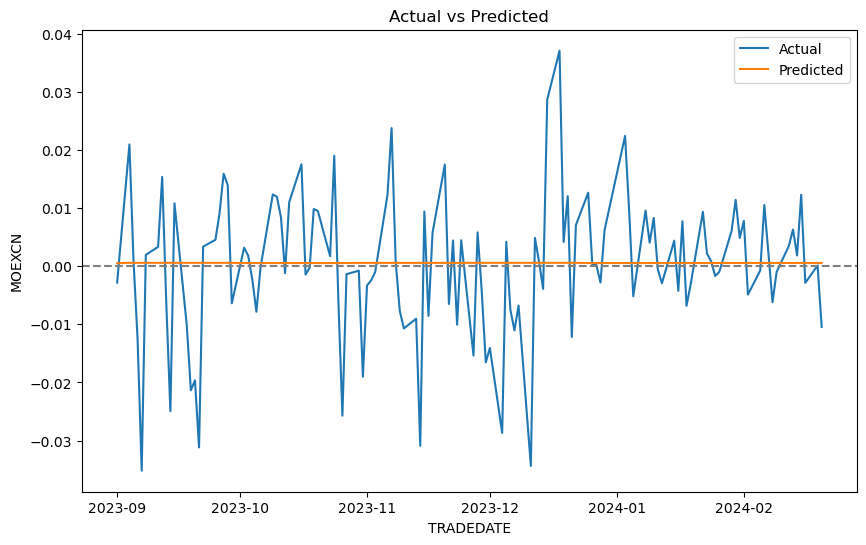

In [45]:
ts.get_visualisation(start_date='2023-09-01')

In [35]:
#Без поиска параметров работает лучше почему-то..
xgb_model = xgb.XGBRegressor()

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


In [36]:
ts.get_model_result(y_pred_list_xgb) 

MASE: 0.83 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 149.24% (на сколько % в среднем модель ошибается)
MDA: 49.88% (% случаев, когда знак прогноза совпадает с фактическим знаком)
ZBMAE: 1.11 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки нулевого прогноза)


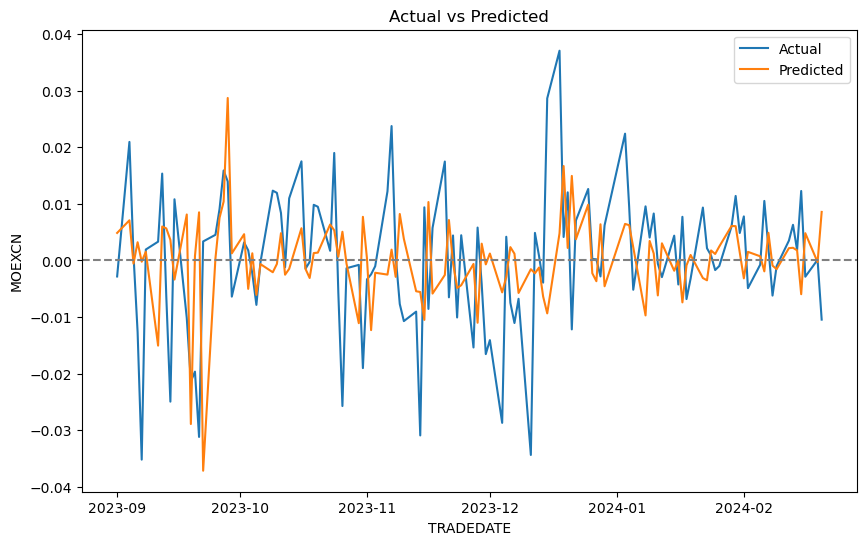

In [37]:
ts.get_visualisation(start_date='2023-09-01')